In [1]:
%load_ext autoreload
%autoreload 2

# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

### Functions

In [3]:
def custom_sat_cmap(basecolor, num, min_s=0.001):

    hsv = rgb_to_hsv(basecolor).tolist()
    new_s_lst = np.linspace(min_s, hsv[1], num)

    new_cmap = []
    for new_s in new_s_lst:
        hsv[1] = new_s
        new_cmap.append(hsv_to_rgb(hsv).tolist())

    return new_cmap

In [4]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [5]:
def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Large-scale experiments

### Initialize

#### Variables

In [6]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = [116, 30, 151]

CMAP = mpl.color_sequences['tab10']
CMAP_L = mpl.color_sequences['tab20b']
CMAP_C = mpl.color_sequences['Set3']
CMAP_H = mpl.colors.LinearSegmentedColormap.from_list("", ['gray','white']),

#### Evaluation data from SM

In [7]:
CATEGORY = '_RQ1'

sm_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'}
    ],

]

#### Evaluation data from EOS

In [8]:
CATEGORY = '_RQ1'

eos_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
    ]
]

#### Evaluation data from OvR

In [9]:
CATEGORY = '_RQ1'

ovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
    ]
]

In [10]:
CATEGORY = '_RQ2'

ovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
    ]
]

In [11]:
CATEGORY = '_RQ3'

ovr_data_info_3_C = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_C_g', 'OvR'], 'label': 'OvR-C'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_b', 'OvR'], 'label': 'OvR-C (batch)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_g', 'OvR'], 'label': 'OvR-C (global)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_C_g', 'OvR'], 'label': 'OvR-C'},
    ]
]

ovr_data_info_3_F = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_1', 'OvR'], 'label': 'OvR-F (1)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F (2)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_3', 'OvR'], 'label': 'OvR-F (3)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F'},
    ]
]

ovr_data_info_3_M = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_M_6', 'OvR'], 'label': 'OvR-M'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_4', 'OvR'], 'label': 'OvR-M (0.4)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_6', 'OvR'], 'label': 'OvR-M (0.6)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_M_6', 'OvR'], 'label': 'OvR-M'},
    ]
]

#### Evaluation data from OSOvR

In [12]:
CATEGORY = '_Tuning'

osovr_data_info_T = [
    [
        None
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_sigma_6', 'OpenSetOvR'], 'label': 'OSOvR (6)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_sigma_8', 'OpenSetOvR'], 'label': 'OSOvR (8)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_sigma_12', 'OpenSetOvR'], 'label': 'OSOvR (12)'},
    ],
    [
        None
    ]
]

In [13]:
CATEGORY = '_RQ1'

osovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
    ]
]

In [14]:
CATEGORY = '_RQ2'

osovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
    ]
]

In [15]:
CATEGORY = '_RQ3'

osovr_data_info_3_C = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_b', 'OpenSetOvR'], 'label': 'OSOvR-C (batch)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C (global)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
    ]
]

osovr_data_info_3_F = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_F_1', 'OpenSetOvR'], 'label': 'OSOvR-F'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_F_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_F_1', 'OpenSetOvR'], 'label': 'OSOvR-F'},
    ]
]

osovr_data_info_3_M = [
    [
        {'info':[f"{SCALE}_1", CATEGORY, f'{ARCHITECTURE}_M_6', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ],
    [
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_4', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)'},
        {'info':[f"{SCALE}_2", CATEGORY, f'{ARCHITECTURE}_M_6', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6)'},
    ],
    [
        {'info':[f"{SCALE}_3", CATEGORY, f'{ARCHITECTURE}_M_6', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ]
]

### 0. Tuning

In [18]:
PROTOCOL = 2

#### OSOvR - Sigma
- Best = 8

In [19]:
data_info = osovr_data_info_T[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_Tuning', 'ResNet_50_sigma_6', 'OpenSetOvR']
['LargeScale_2', '_Tuning', 'ResNet_50_sigma_8', 'OpenSetOvR']
['LargeScale_2', '_Tuning', 'ResNet_50_sigma_12', 'OpenSetOvR']


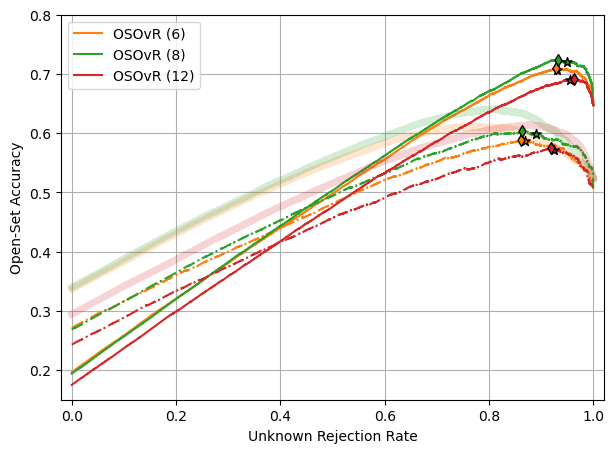

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5567	0.9105	0.4674	0.6114	0.5875	0.7073	0.5882	0.7094
0.5500	0.9121	0.4802	0.6409	0.5987	0.7202	0.6033	0.7240
0.4960	0.9026	0.4023	0.6142	0.5708	0.6899	0.5744	0.6908


In [21]:
evals.plot_OSAC(data_info, [CMAP[1],CMAP[2],CMAP[3]], figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

#### Loss weighting - C, F, M 
- Best C (OvR/OSOvR) : global / global
- Best F (OvR/OSOvR) : 2 / 1
- Best M (OvR/OSOvR) : 0.6 / 0.6

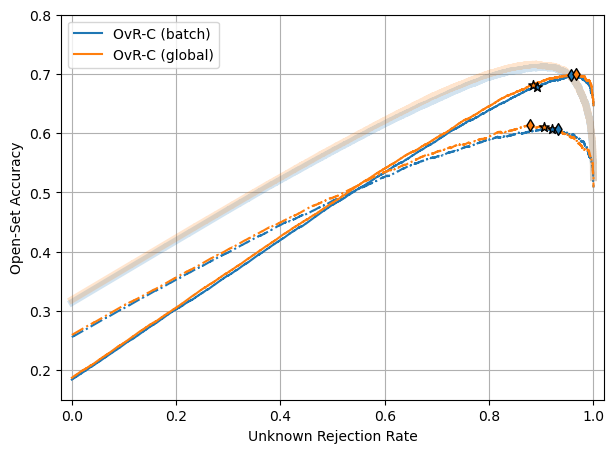

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5213	0.9245	0.4115	0.7126	0.6062	0.6781	0.6075	0.6976
0.5300	0.9208	0.4257	0.7165	0.6111	0.6821	0.6134	0.7000


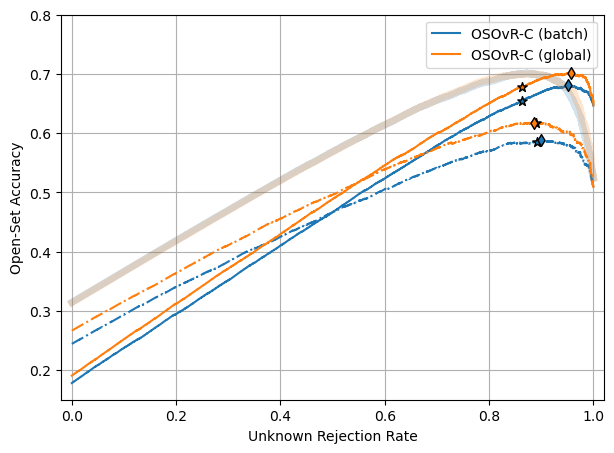

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5047	0.9118	0.3846	0.7016	0.5856	0.6548	0.5885	0.6816
0.5400	0.9227	0.4394	0.7000	0.6167	0.6774	0.6177	0.7016


In [97]:
PROTOCOL = 2

data_info = ovr_data_info_3_C[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_C[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

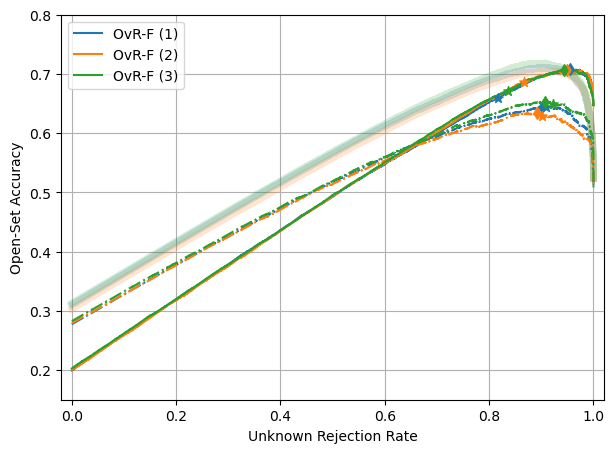

		oosa			iosa
acc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5647	0.4540	0.7107	0.6443	0.6595	0.6449	0.7078
0.5667	0.4545	0.7049	0.6298	0.6866	0.6344	0.7059
0.5747	0.4593	0.7182	0.6485	0.6713	0.6528	0.7073


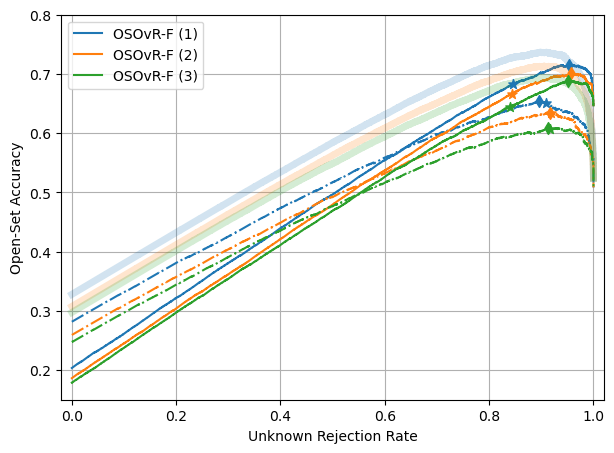

		oosa			iosa
acc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5767	0.4682	0.7366	0.6518	0.6826	0.6538	0.7151
0.5280	0.4212	0.7131	0.6341	0.6666	0.6344	0.7012
0.5067	0.3886	0.6941	0.6066	0.6445	0.6092	0.6889


In [20]:
data_info = ovr_data_info_3_F[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_F[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

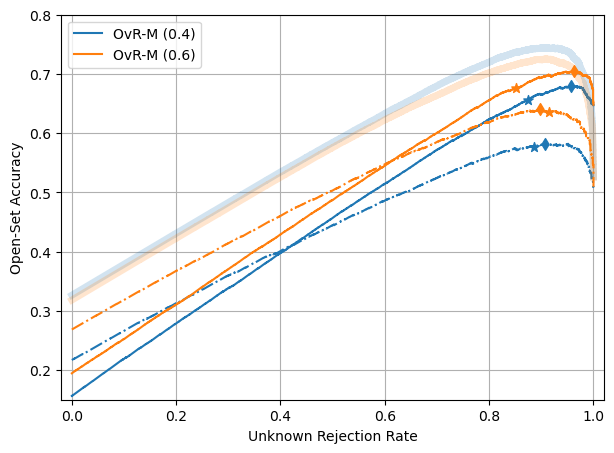

		oosa			iosa
acc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.4433	0.3538	0.7445	0.5770	0.6560	0.5823	0.6800
0.5513	0.4426	0.7254	0.6361	0.6758	0.6400	0.7045


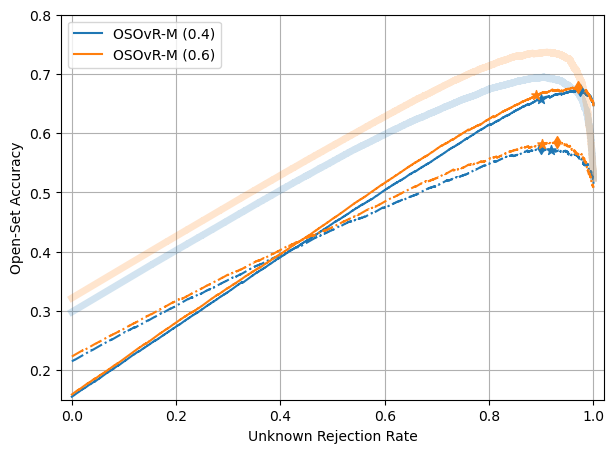

		oosa			iosa
acc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.4393	0.3323	0.6948	0.5721	0.6579	0.5748	0.6725
0.4500	0.3553	0.7368	0.5810	0.6642	0.5859	0.6772


In [21]:
data_info = ovr_data_info_3_M[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_M[PROTOCOL-1]
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

### 1. Softmax-based vs. OvR-based loss

#### Protocol 1

In [72]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']


['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']
			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5698	0.9743	0.5330	0.6148	0.5884	0.7268	0.5891	0.7281
0.5631	0.9583	0.5143	0.6458	0.5923	0.7350	0.5954	0.7360
0.5190	0.9525	0.4608	0.6453	0.5570	0.6999	0.5601	0.7009


<Figure size 500x500 with 0 Axes>

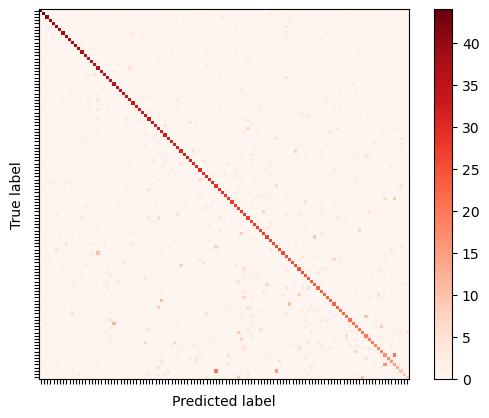

<Figure size 500x500 with 0 Axes>

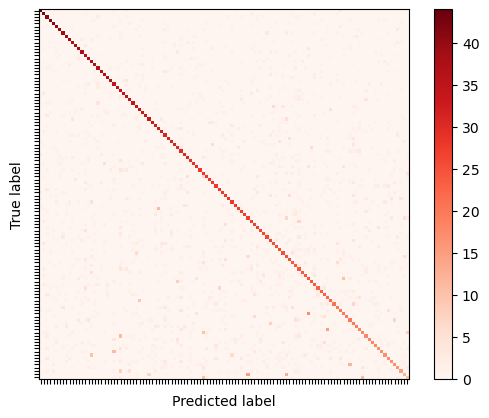

<Figure size 500x500 with 0 Axes>

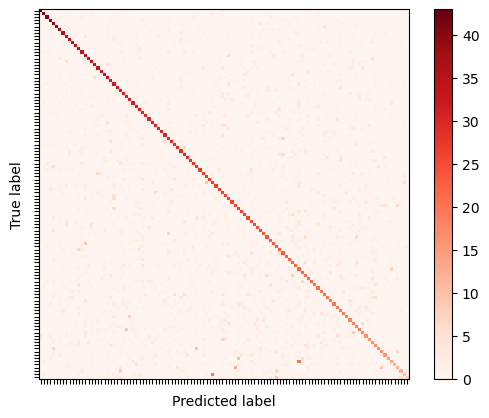

In [65]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=False, set_cmap_range=None,
                         show_numbers=False, diag_sort=True)

##### Appendix

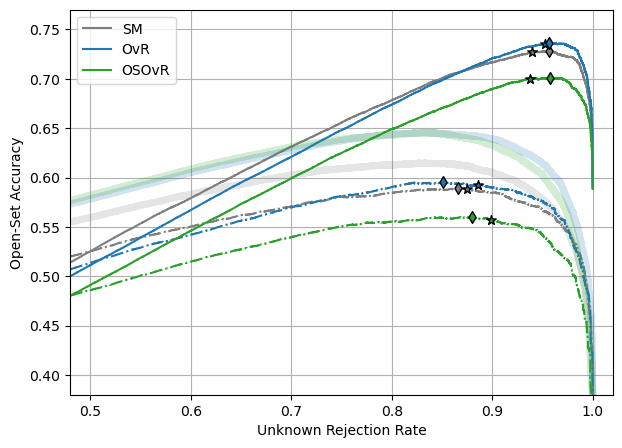

In [75]:
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.48, 1.02),(0.38,0.77)))

#### Protocol 2

In [76]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']


['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']
			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5627	0.9435	0.4715	0.6239	0.5823	0.7118	0.5898	0.7129
0.5673	0.9334	0.4711	0.6302	0.5984	0.7064	0.6007	0.7078
0.5500	0.9121	0.4802	0.6409	0.5987	0.7202	0.6033	0.7240


<Figure size 500x500 with 0 Axes>

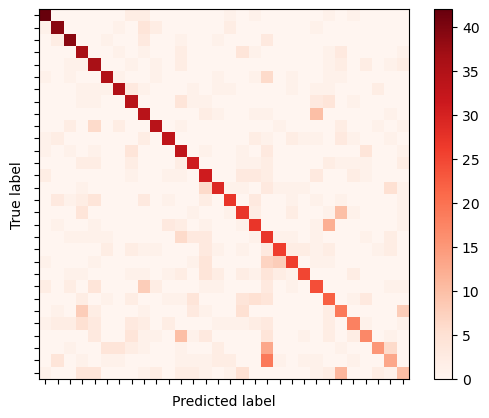

<Figure size 500x500 with 0 Axes>

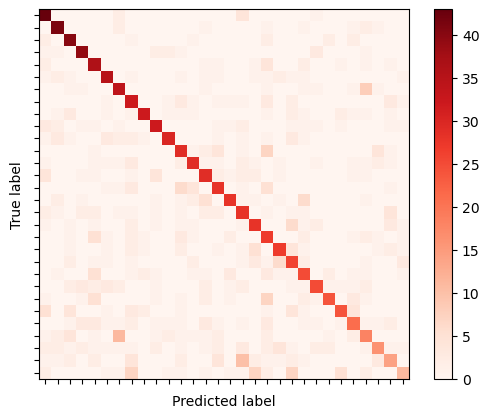

<Figure size 500x500 with 0 Axes>

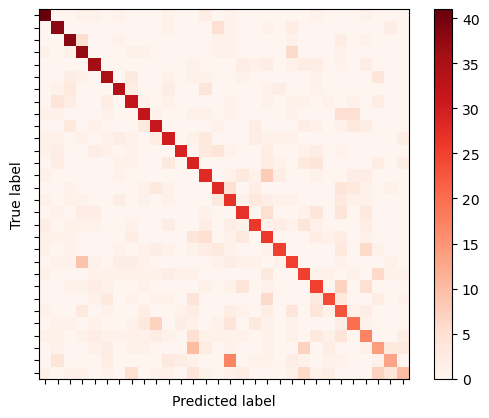

In [62]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=False, set_cmap_range=None,
                         show_numbers=False, diag_sort=True)

##### Appendix

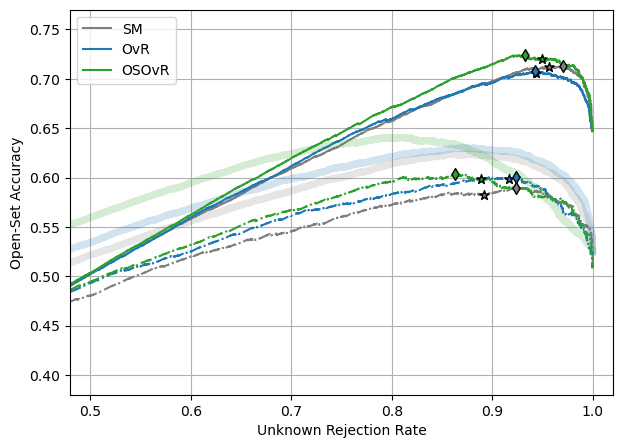

In [77]:
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.48, 1.02),(0.38,0.77)))

#### Protocol 3

In [78]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']


['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6374	0.9798	0.5493	0.6461	0.5670	0.6644	0.5735	0.6658
0.5750	0.9460	0.4919	0.6587	0.5525	0.6506	0.5600	0.6543
0.4809	0.8886	0.4064	0.6607	0.4559	0.5718	0.4993	0.6027


<Figure size 500x500 with 0 Axes>

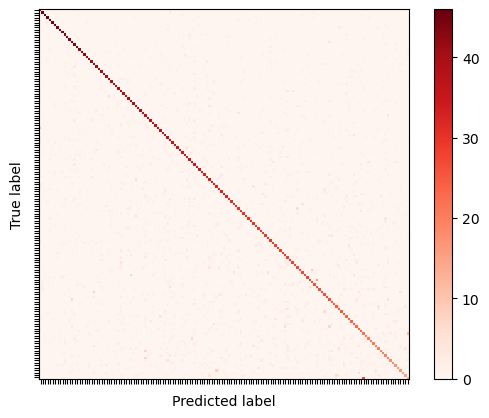

<Figure size 500x500 with 0 Axes>

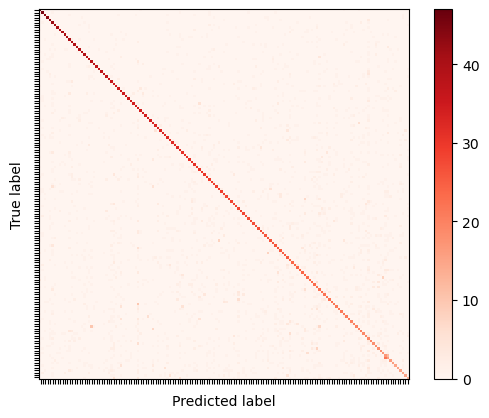

<Figure size 500x500 with 0 Axes>

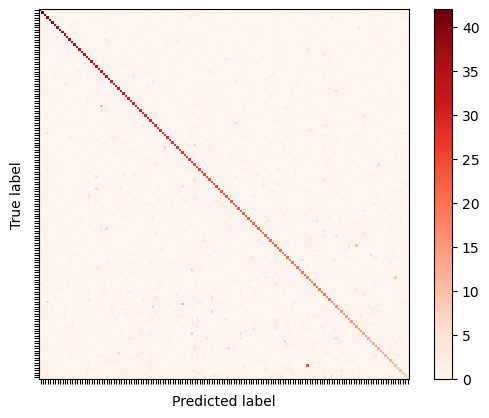

In [63]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=False, set_cmap_range=None,
                         show_numbers=False, diag_sort=True)

##### Appendix

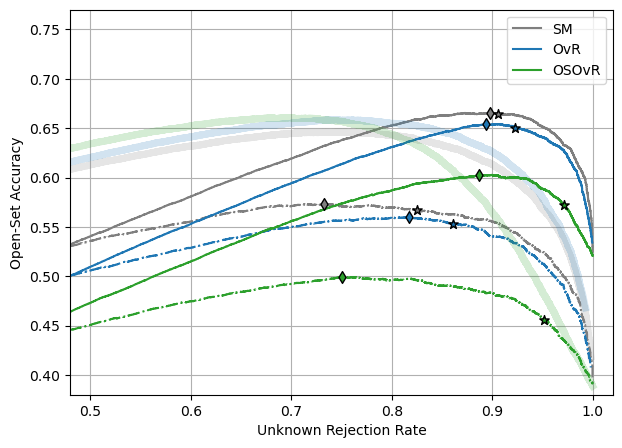

In [79]:
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.48, 1.02),(0.38,0.77)))

### 2. Examine the effect of the number of negatives in training.

#### Protocol 1

In [73]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5698	0.9743	0.5330	0.6148	0.5884	0.7268	0.5891	0.7281
0.5629	0.9553	0.5497	0.7685	0.6661	0.7500	0.6750	0.7765
0.5631	0.9583	0.5143	0.6458	0.5923	0.7350	0.5954	0.7360
0.5691	0.9484	0.5164	0.7643	0.6290	0.6004	0.6444	0.7456


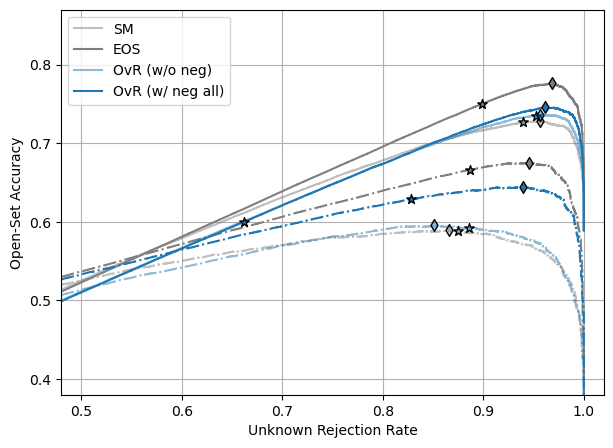

In [75]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[0],0.5),CMAP[0],],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

In [76]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5698	0.9743	0.5330	0.6148	0.5884	0.7268	0.5891	0.7281
0.5629	0.9553	0.5497	0.7685	0.6661	0.7500	0.6750	0.7765
0.5190	0.9525	0.4608	0.6453	0.5570	0.6999	0.5601	0.7009
0.5098	0.9092	0.4527	0.7687	0.5819	0.5799	0.5950	0.7082


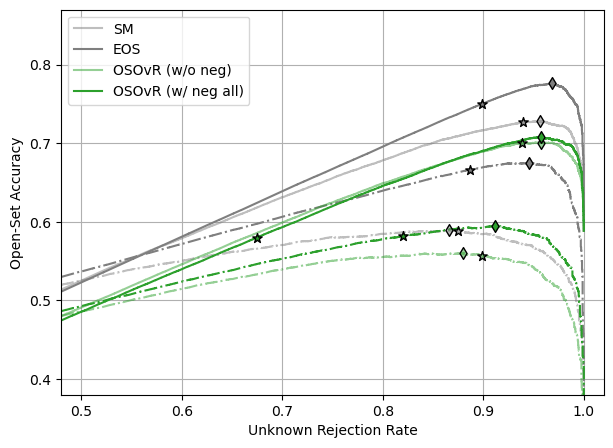

In [77]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[2],0.5),CMAP[2]], 
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

#### Protocol 2

In [78]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5627	0.9435	0.4715	0.6239	0.5823	0.7118	0.5898	0.7129
0.5367	0.8952	0.4449	0.7480	0.6164	0.6819	0.6233	0.7089
0.5673	0.9334	0.4711	0.6302	0.5984	0.7064	0.6007	0.7078
0.5680	0.9199	0.4607	0.7248	0.6502	0.6920	0.6518	0.7172


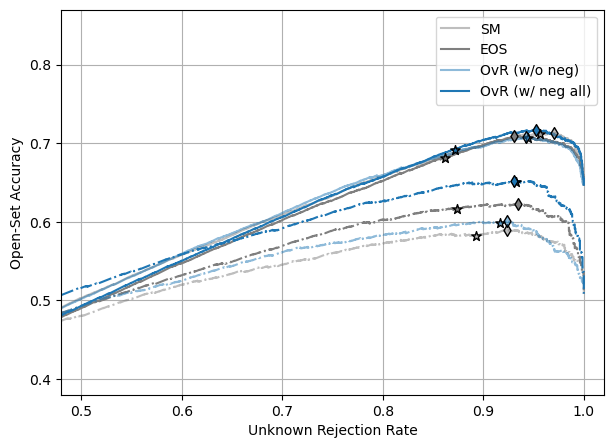

In [79]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[0],0.5),CMAP[0],], 
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

In [80]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5627	0.9435	0.4715	0.6239	0.5823	0.7118	0.5898	0.7129
0.5367	0.8952	0.4449	0.7480	0.6164	0.6819	0.6233	0.7089
0.5500	0.9121	0.4802	0.6409	0.5987	0.7202	0.6033	0.7240
0.5173	0.9026	0.4121	0.7151	0.6174	0.6511	0.6210	0.7002


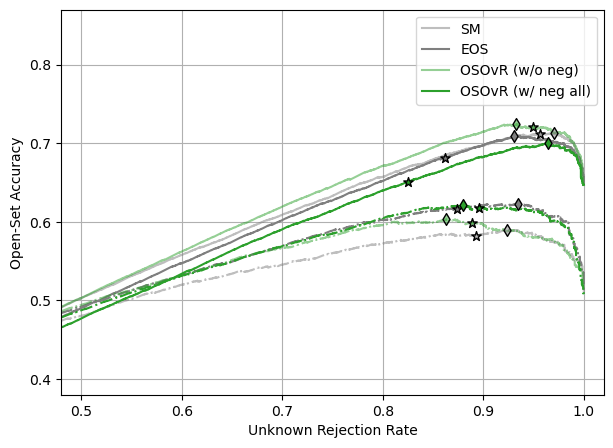

In [82]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[2],0.5),CMAP[2],], 
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

#### Protocol 3

In [83]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6374	0.9798	0.5493	0.6461	0.5670	0.6644	0.5735	0.6658
0.5645	0.9350	0.4910	0.7523	0.5842	0.6410	0.5875	0.6474
0.5750	0.9460	0.4919	0.6587	0.5525	0.6506	0.5600	0.6543
0.5823	0.9444	0.4974	0.7328	0.6123	0.6237	0.6138	0.6580


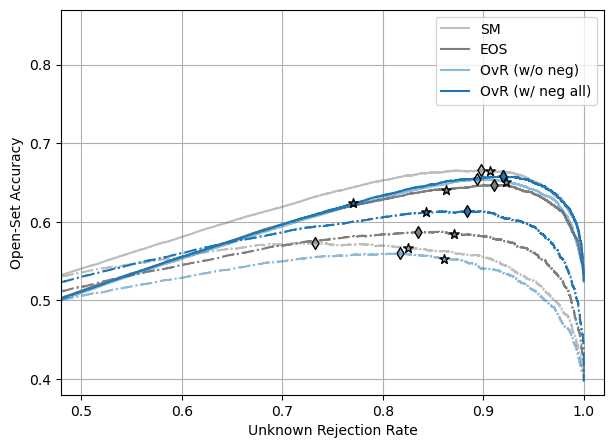

In [84]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[0],0.5),CMAP[0],], 
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

In [85]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6374	0.9798	0.5493	0.6461	0.5670	0.6644	0.5735	0.6658
0.5645	0.9350	0.4910	0.7523	0.5842	0.6410	0.5875	0.6474
0.4809	0.8886	0.4064	0.6607	0.4559	0.5718	0.4993	0.6027
0.4862	0.8860	0.4102	0.7655	0.5193	0.6084	0.5399	0.6123


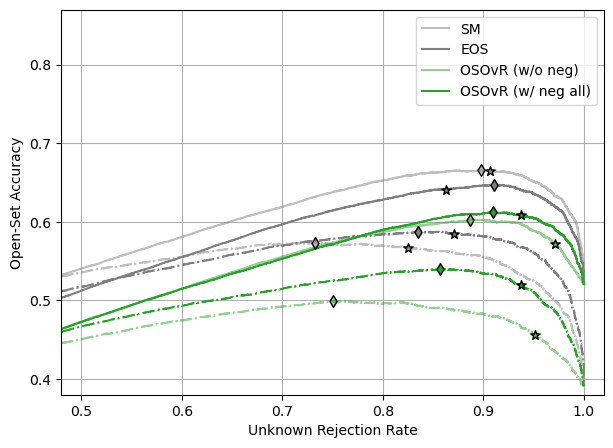

In [86]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[2],0.5),CMAP[2],], 
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

### 3. Comparing the type of loss weighting

#### Protocol 1

In [64]:
PROTOCOL = 1

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_g', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_6', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5691	0.9484	0.5164	0.7643	0.6290	0.6004	0.6444	0.7456
0.5286	0.9636	0.5032	0.7391	0.6303	0.7130	0.6345	0.7456
0.5648	0.9550	0.5148	0.7462	0.6256	0.6007	0.6405	0.7383
0.5145	0.9407	0.4598	0.7567	0.5728	0.5881	0.5922	0.7097
average	std	model
0.5468	0.157	OvR (w/ neg all)
0.4737	0.165	OvR-C
0.5585	0.159	OvR-F
0.5704	0.159	OvR-M


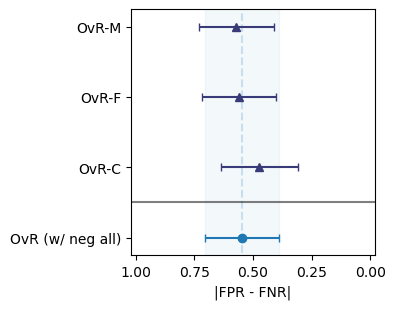

In [65]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

results = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02))

In [93]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_g', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.5698	0.9743	0.5330	0.6148	0.5884	0.7268	0.5891	0.7281
0.5629	0.9553	0.5497	0.7685	0.6661	0.7500	0.6750	0.7765
0.5631	0.9583	0.5143	0.6458	0.5923	0.7350	0.5954	0.7360
0.5691	0.9484	0.5164	0.7643	0.6290	0.6004	0.6444	0.7456
0.5286	0.9636	0.5032	0.7391	0.6303	0.7130	0.6345	0.7456


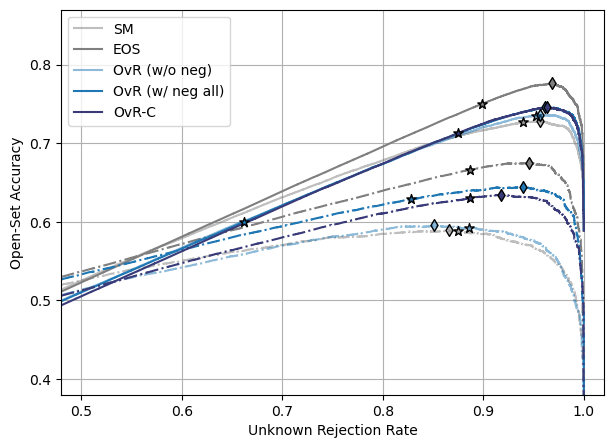

In [94]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[0],0.5),CMAP[0],CMAP_L[0],],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

In [66]:
PROTOCOL = 1

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_1', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_6', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5098	0.9092	0.4527	0.7687	0.5819	0.5799	0.5950	0.7082
0.4876	0.9536	0.4457	0.7319	0.5836	0.6582	0.5880	0.7045
0.5372	0.9314	0.4892	0.7722	0.6138	0.6248	0.6221	0.7245
0.3060	0.8260	0.2534	0.7597	0.4094	0.5809	0.4134	0.6051
average	std	model
0.6377	0.141	OSOvR (w/ neg all)
0.5222	0.160	OSOvR-C
0.5884	0.156	OSOvR-F
0.8108	0.128	OSOvR-M


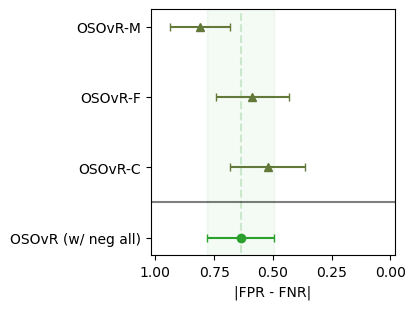

In [67]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

results = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02))

In [96]:
PROTOCOL = 1

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.5698	0.9743	0.5330	0.6148	0.5884	0.7268	0.5891	0.7281
0.5629	0.9553	0.5497	0.7685	0.6661	0.7500	0.6750	0.7765
0.5190	0.9525	0.4608	0.6453	0.5570	0.6999	0.5601	0.7009
0.5098	0.9092	0.4527	0.7687	0.5819	0.5799	0.5950	0.7082
0.4876	0.9536	0.4457	0.7319	0.5836	0.6582	0.5880	0.7045


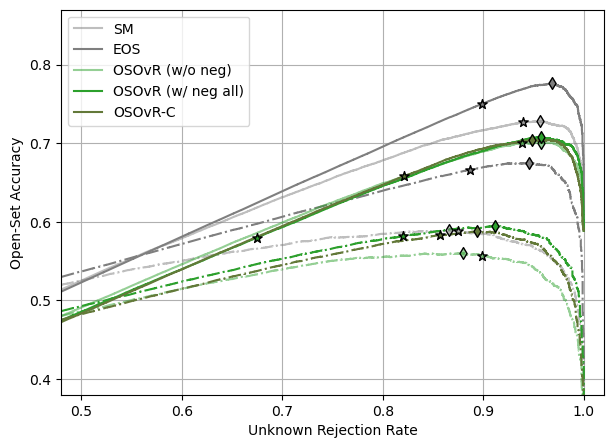

In [97]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[2],0.5),CMAP[2],CMAP_L[4]],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

#### Protocol 2

In [68]:
PROTOCOL = 2

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1][-1:] + ovr_data_info_3_F[PROTOCOL-1][1:2] + ovr_data_info_3_M[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_g', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_6', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5680	0.9199	0.4607	0.7248	0.6502	0.6920	0.6518	0.7172
0.5300	0.9208	0.4257	0.7165	0.6111	0.6821	0.6134	0.7000
0.5667	0.9261	0.4545	0.7049	0.6298	0.6866	0.6344	0.7059
0.5513	0.9123	0.4426	0.7254	0.6361	0.6758	0.6400	0.7045
average	std	model
0.6446	0.135	OvR (w/ neg all)
0.5006	0.134	OvR-C (global)
0.6619	0.143	OvR-F (2)
0.6298	0.131	OvR-M (0.6)


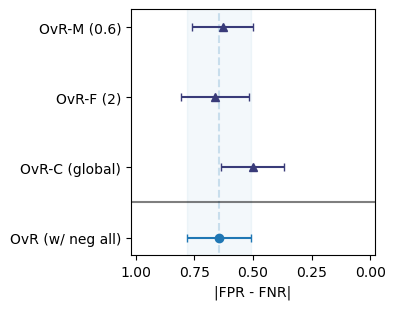

In [69]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

results = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02))

In [100]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_g', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5627	0.9435	0.4715	0.6239	0.5823	0.7118	0.5898	0.7129
0.5367	0.8952	0.4449	0.7480	0.6164	0.6819	0.6233	0.7089
0.5673	0.9334	0.4711	0.6302	0.5984	0.7064	0.6007	0.7078
0.5680	0.9199	0.4607	0.7248	0.6502	0.6920	0.6518	0.7172
0.5300	0.9208	0.4257	0.7165	0.6111	0.6821	0.6134	0.7000


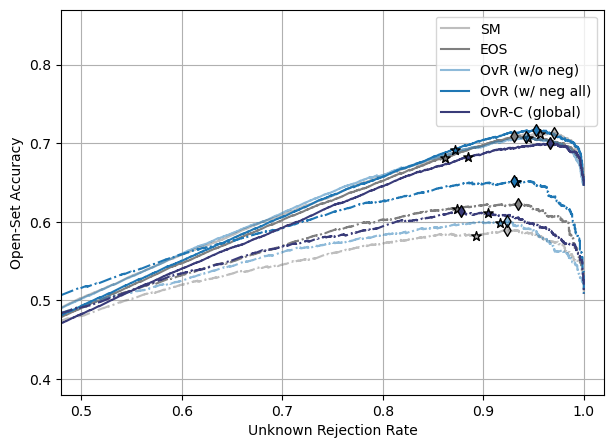

In [101]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[0],0.5),CMAP[0],CMAP_L[0],],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

In [70]:
PROTOCOL = 2

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1][-1:] + osovr_data_info_3_F[PROTOCOL-1][0:1] + osovr_data_info_3_M[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_1', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_6', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5173	0.9026	0.4121	0.7151	0.6174	0.6511	0.6210	0.7002
0.5400	0.9227	0.4394	0.7000	0.6167	0.6774	0.6177	0.7016
0.5767	0.9190	0.4682	0.7366	0.6518	0.6826	0.6538	0.7151
0.4500	0.8395	0.3553	0.7368	0.5810	0.6642	0.5859	0.6772
average	std	model
0.7150	0.117	OSOvR (w/ neg all)
0.5040	0.113	OSOvR-C (global)
0.6541	0.133	OSOvR-F (1)
0.7274	0.120	OSOvR-M (0.6)


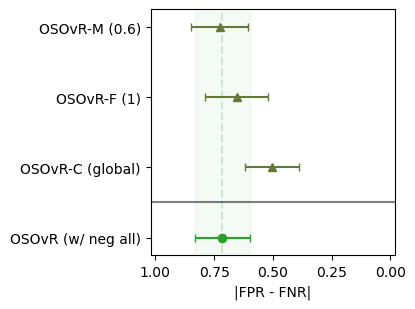

In [72]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

results = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02))

In [102]:
PROTOCOL = 2

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_2', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5627	0.9435	0.4715	0.6239	0.5823	0.7118	0.5898	0.7129
0.5367	0.8952	0.4449	0.7480	0.6164	0.6819	0.6233	0.7089
0.5500	0.9121	0.4802	0.6409	0.5987	0.7202	0.6033	0.7240
0.5173	0.9026	0.4121	0.7151	0.6174	0.6511	0.6210	0.7002
0.5400	0.9227	0.4394	0.7000	0.6167	0.6774	0.6177	0.7016


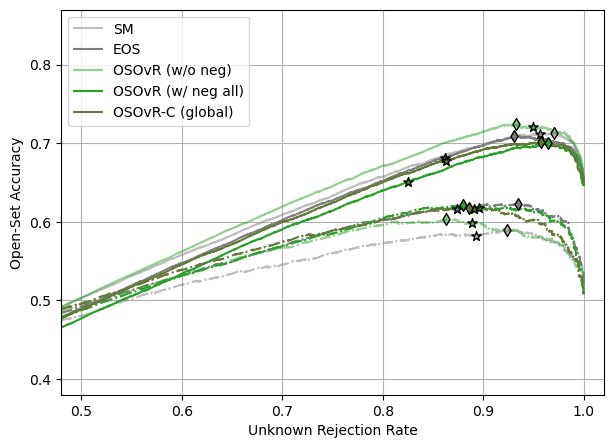

In [103]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[2],0.5),CMAP[2],CMAP_L[4],],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

#### Protocol 3

In [19]:
PROTOCOL = 3

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_g', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_6', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.5823	0.9444	0.4974	0.7328	0.6123	0.6237	0.6138	0.6580
0.5140	0.9574	0.4338	0.6879	0.5398	0.6170	0.5425	0.6178
0.5693	0.9454	0.4829	0.7102	0.6013	0.6357	0.6019	0.6515
0.5479	0.9358	0.4568	0.7213	0.5865	0.6257	0.5875	0.6399
average	std	model
0.5787	0.181	OvR (w/ neg all)
0.4852	0.184	OvR-C
0.6031	0.183	OvR-F
0.5760	0.190	OvR-M


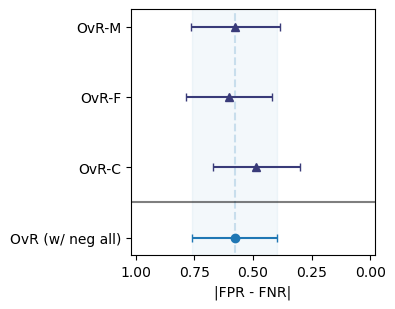

In [20]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

results = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02))

In [21]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_g', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6374	0.9798	0.5493	0.6461	0.5670	0.6644	0.5735	0.6658
0.5645	0.9350	0.4910	0.7523	0.5842	0.6410	0.5875	0.6474
0.5750	0.9460	0.4919	0.6587	0.5525	0.6506	0.5600	0.6543
0.5823	0.9444	0.4974	0.7328	0.6123	0.6237	0.6138	0.6580
0.5140	0.9574	0.4338	0.6879	0.5398	0.6170	0.5425	0.6178


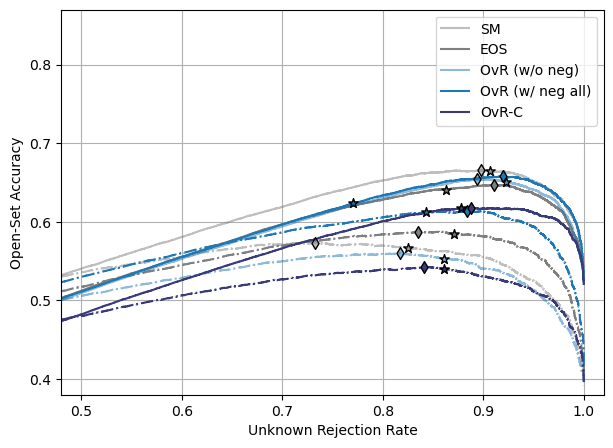

In [22]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[0],0.5),CMAP[0],CMAP_L[0],],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

In [23]:
PROTOCOL = 3

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_1', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_6', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.4862	0.8860	0.4102	0.7655	0.5193	0.6084	0.5399	0.6123
0.4352	0.9051	0.3336	0.7190	0.4452	0.5502	0.4645	0.5537
0.4927	0.8956	0.4119	0.7656	0.5360	0.6137	0.5468	0.6137
0.3183	0.8486	0.2103	0.7134	0.3892	0.5076	0.3910	0.5207
average	std	model
0.7824	0.126	OSOvR (w/ neg all)
0.6284	0.163	OSOvR-C
0.7524	0.129	OSOvR-F
0.9322	0.055	OSOvR-M


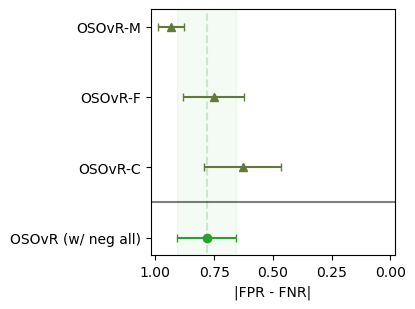

In [24]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

results = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02))

In [29]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6374	0.9798	0.5493	0.6461	0.5670	0.6644	0.5735	0.6658
0.5645	0.9350	0.4910	0.7523	0.5842	0.6410	0.5875	0.6474
0.4809	0.8886	0.4064	0.6607	0.4559	0.5718	0.4993	0.6027
0.4862	0.8860	0.4102	0.7655	0.5193	0.6084	0.5399	0.6123
0.4352	0.9051	0.3336	0.7190	0.4452	0.5502	0.4645	0.5537


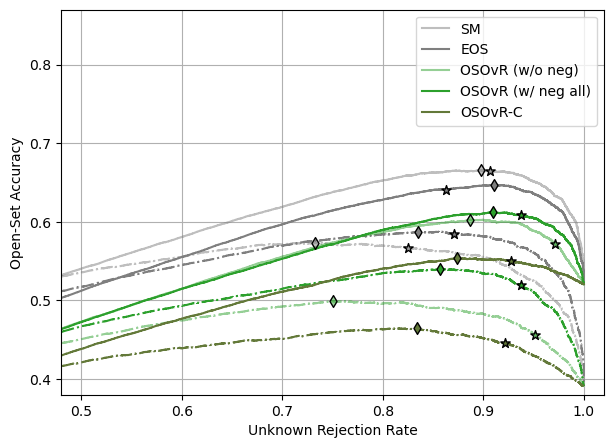

In [30]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [(*CMAP[7],0.5),CMAP[7],
                            (*CMAP[2],0.5),CMAP[2],CMAP_L[4],],
                figsize=(7,5), lim=((0.48, 1.02),(0.38,0.87)),
                show_val=False)

### 4. Training progress

In [16]:
log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [38]:
ITEM_IDX = 2
log_item_list[ITEM_IDX][0]

'Acc/train'

#### Protocol 1

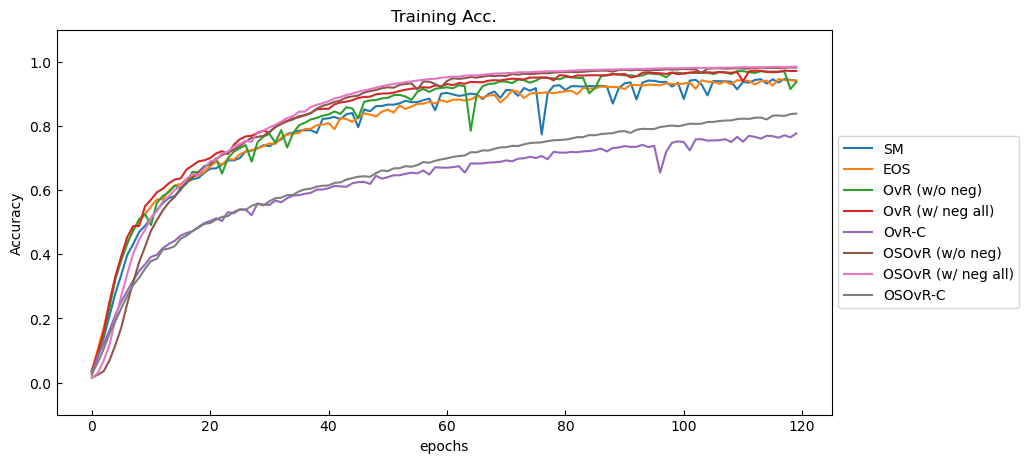

In [39]:
PROTOCOL = 1

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 2

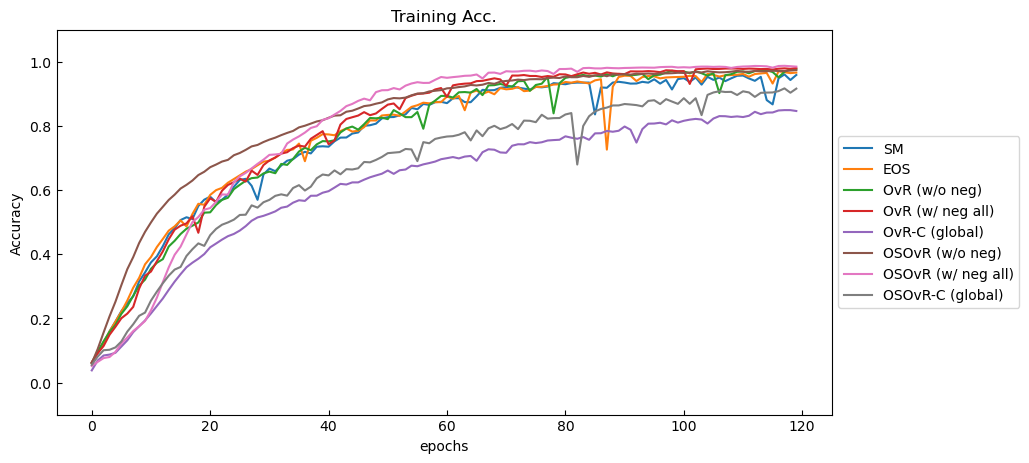

In [40]:
PROTOCOL = 2

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1][-1:]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 3

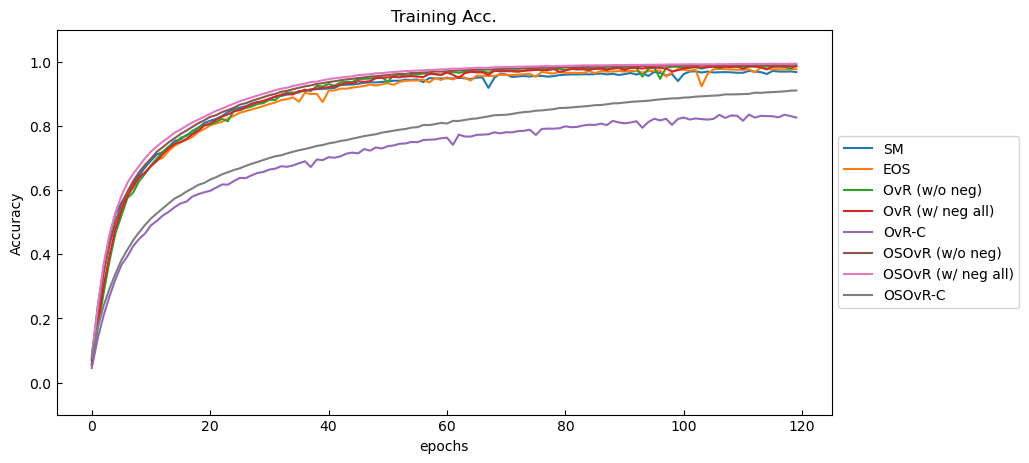

In [41]:
PROTOCOL = 3

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')
